In [5]:
import sys, os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3' 
sys.path.append(os.path.abspath(os.path.join('../../../BayesFlow')))

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from functools import partial
import pickle

In [6]:
import tensorflow as tf

In [7]:
from bayesflow import benchmarks
from bayesflow.amortizers import AmortizedPosterior, AmortizedLikelihood, AmortizedPosteriorLikelihood
from bayesflow.networks import InvertibleNetwork, InvariantNetwork
from bayesflow.trainers import Trainer
from bayesflow.diagnostics import plot_sbc_ecdf, plot_recovery, plot_posterior_2d, plot_losses, plot_latent_space_2d

# Two Moons

In [8]:
benchmark_name = 'two_moons'
benchmark = benchmarks.Benchmark(benchmark_name)

INFO:root:Performing 2 pilot runs with the two_moons model...
INFO:root:Shape of parameter batch after 2 pilot simulations: (batch_size = 2, 2)
INFO:root:Shape of simulation batch after 2 pilot simulations: (batch_size = 2, 2)
INFO:root:No optional prior non-batchable context provided.
INFO:root:No optional prior batchable context provided.
INFO:root:No optional simulation non-batchable context provided.
INFO:root:No optional simulation batchable context provided.


# Amortizer and Trainer

In [9]:
amortizer = AmortizedPosteriorLikelihood(
    AmortizedPosterior(InvertibleNetwork(num_params=2, num_coupling_layers=5, coupling_design='interleaved', permutation='learnable')),
    AmortizedLikelihood(InvertibleNetwork(num_params=2, num_coupling_layers=5, coupling_design='interleaved', permutation='learnable'))
)

In [10]:
trainer = Trainer(
    amortizer=amortizer,
    generative_model=benchmark.generative_model,
    configurator=benchmark.configurator,
    checkpoint_path=f'checkpoints/{benchmark_name}',
    max_to_keep=1,
    memory=False   
)

INFO:root:Initialized empty loss history.
INFO:root:Initialized networks from scratch.
INFO:root:Performing a consistency check with provided components...
INFO:root:Done.


# Training
Uncomment for training. Wall time with GPU: approx. 18min 22s

In [11]:
EPOCHS = 50
SIMULATION_BUDGET = 10000
N_VAL = 300
BATCH_SIZE = 32

train_data = trainer.generative_model(SIMULATION_BUDGET)

In [12]:
%%time
h = trainer.train_offline(train_data, EPOCHS, BATCH_SIZE, validation_sims=N_VAL)

INFO:root:Generated 300 simulations for validation.


Training epoch 1:   0%|          | 0/313 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 1, Post.Loss: -1.698, Lik.Loss: -2.919


Training epoch 2:   0%|          | 0/313 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 2, Post.Loss: -2.334, Lik.Loss: -3.350


Training epoch 3:   0%|          | 0/313 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 3, Post.Loss: -2.369, Lik.Loss: -3.441


Training epoch 4:   0%|          | 0/313 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 4, Post.Loss: -2.732, Lik.Loss: -3.403


Training epoch 5:   0%|          | 0/313 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 5, Post.Loss: -2.721, Lik.Loss: -3.692


Training epoch 6:   0%|          | 0/313 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 6, Post.Loss: -2.804, Lik.Loss: -3.701


Training epoch 7:   0%|          | 0/313 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 7, Post.Loss: -2.640, Lik.Loss: -3.826


Training epoch 8:   0%|          | 0/313 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 8, Post.Loss: -2.920, Lik.Loss: -3.923


Training epoch 9:   0%|          | 0/313 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 9, Post.Loss: -3.068, Lik.Loss: -3.873


Training epoch 10:   0%|          | 0/313 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 10, Post.Loss: -3.095, Lik.Loss: -3.921


Training epoch 11:   0%|          | 0/313 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 11, Post.Loss: -3.161, Lik.Loss: -3.766


Training epoch 12:   0%|          | 0/313 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 12, Post.Loss: -3.129, Lik.Loss: -4.049


Training epoch 13:   0%|          | 0/313 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 13, Post.Loss: -3.049, Lik.Loss: -4.085


Training epoch 14:   0%|          | 0/313 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 14, Post.Loss: -3.205, Lik.Loss: -4.023


Training epoch 15:   0%|          | 0/313 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 15, Post.Loss: -3.206, Lik.Loss: -3.862


Training epoch 16:   0%|          | 0/313 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 16, Post.Loss: -3.222, Lik.Loss: -3.868


Training epoch 17:   0%|          | 0/313 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 17, Post.Loss: -3.310, Lik.Loss: -4.072


Training epoch 18:   0%|          | 0/313 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 18, Post.Loss: -3.243, Lik.Loss: -4.078


Training epoch 19:   0%|          | 0/313 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 19, Post.Loss: -3.172, Lik.Loss: -4.101


Training epoch 20:   0%|          | 0/313 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 20, Post.Loss: -3.296, Lik.Loss: -4.071


Training epoch 21:   0%|          | 0/313 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 21, Post.Loss: -3.302, Lik.Loss: -4.121


Training epoch 22:   0%|          | 0/313 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 22, Post.Loss: -3.159, Lik.Loss: -4.017


Training epoch 23:   0%|          | 0/313 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 23, Post.Loss: -3.221, Lik.Loss: -4.142


Training epoch 24:   0%|          | 0/313 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 24, Post.Loss: -3.322, Lik.Loss: -4.032


Training epoch 25:   0%|          | 0/313 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 25, Post.Loss: -3.370, Lik.Loss: -4.128


Training epoch 26:   0%|          | 0/313 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 26, Post.Loss: -3.263, Lik.Loss: -4.177


Training epoch 27:   0%|          | 0/313 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 27, Post.Loss: -3.381, Lik.Loss: -4.071


Training epoch 28:   0%|          | 0/313 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 28, Post.Loss: -3.430, Lik.Loss: -4.151


Training epoch 29:   0%|          | 0/313 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 29, Post.Loss: -3.381, Lik.Loss: -4.156


Training epoch 30:   0%|          | 0/313 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 30, Post.Loss: -3.369, Lik.Loss: -4.141


Training epoch 31:   0%|          | 0/313 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 31, Post.Loss: -3.414, Lik.Loss: -4.214


Training epoch 32:   0%|          | 0/313 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 32, Post.Loss: -3.370, Lik.Loss: -4.195


Training epoch 33:   0%|          | 0/313 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 33, Post.Loss: -3.430, Lik.Loss: -4.202


Training epoch 34:   0%|          | 0/313 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 34, Post.Loss: -3.440, Lik.Loss: -4.187


Training epoch 35:   0%|          | 0/313 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 35, Post.Loss: -3.390, Lik.Loss: -4.168


Training epoch 36:   0%|          | 0/313 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 36, Post.Loss: -3.464, Lik.Loss: -4.226


Training epoch 37:   0%|          | 0/313 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 37, Post.Loss: -3.482, Lik.Loss: -4.227


Training epoch 38:   0%|          | 0/313 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 38, Post.Loss: -3.511, Lik.Loss: -4.244


Training epoch 39:   0%|          | 0/313 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 39, Post.Loss: -3.476, Lik.Loss: -4.176


Training epoch 40:   0%|          | 0/313 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 40, Post.Loss: -3.516, Lik.Loss: -4.231


Training epoch 41:   0%|          | 0/313 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 41, Post.Loss: -3.452, Lik.Loss: -4.241


Training epoch 42:   0%|          | 0/313 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 42, Post.Loss: -3.513, Lik.Loss: -4.269


Training epoch 43:   0%|          | 0/313 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 43, Post.Loss: -3.523, Lik.Loss: -4.278


Training epoch 44:   0%|          | 0/313 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 44, Post.Loss: -3.510, Lik.Loss: -4.270


Training epoch 45:   0%|          | 0/313 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 45, Post.Loss: -3.518, Lik.Loss: -4.279


Training epoch 46:   0%|          | 0/313 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 46, Post.Loss: -3.530, Lik.Loss: -4.282


Training epoch 47:   0%|          | 0/313 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 47, Post.Loss: -3.531, Lik.Loss: -4.281


Training epoch 48:   0%|          | 0/313 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 48, Post.Loss: -3.529, Lik.Loss: -4.283


Training epoch 49:   0%|          | 0/313 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 49, Post.Loss: -3.531, Lik.Loss: -4.281


Training epoch 50:   0%|          | 0/313 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 50, Post.Loss: -3.532, Lik.Loss: -4.282


CPU times: user 26min 14s, sys: 4min 50s, total: 31min 5s
Wall time: 18min 31s


# Validation

## Loss Trajectories

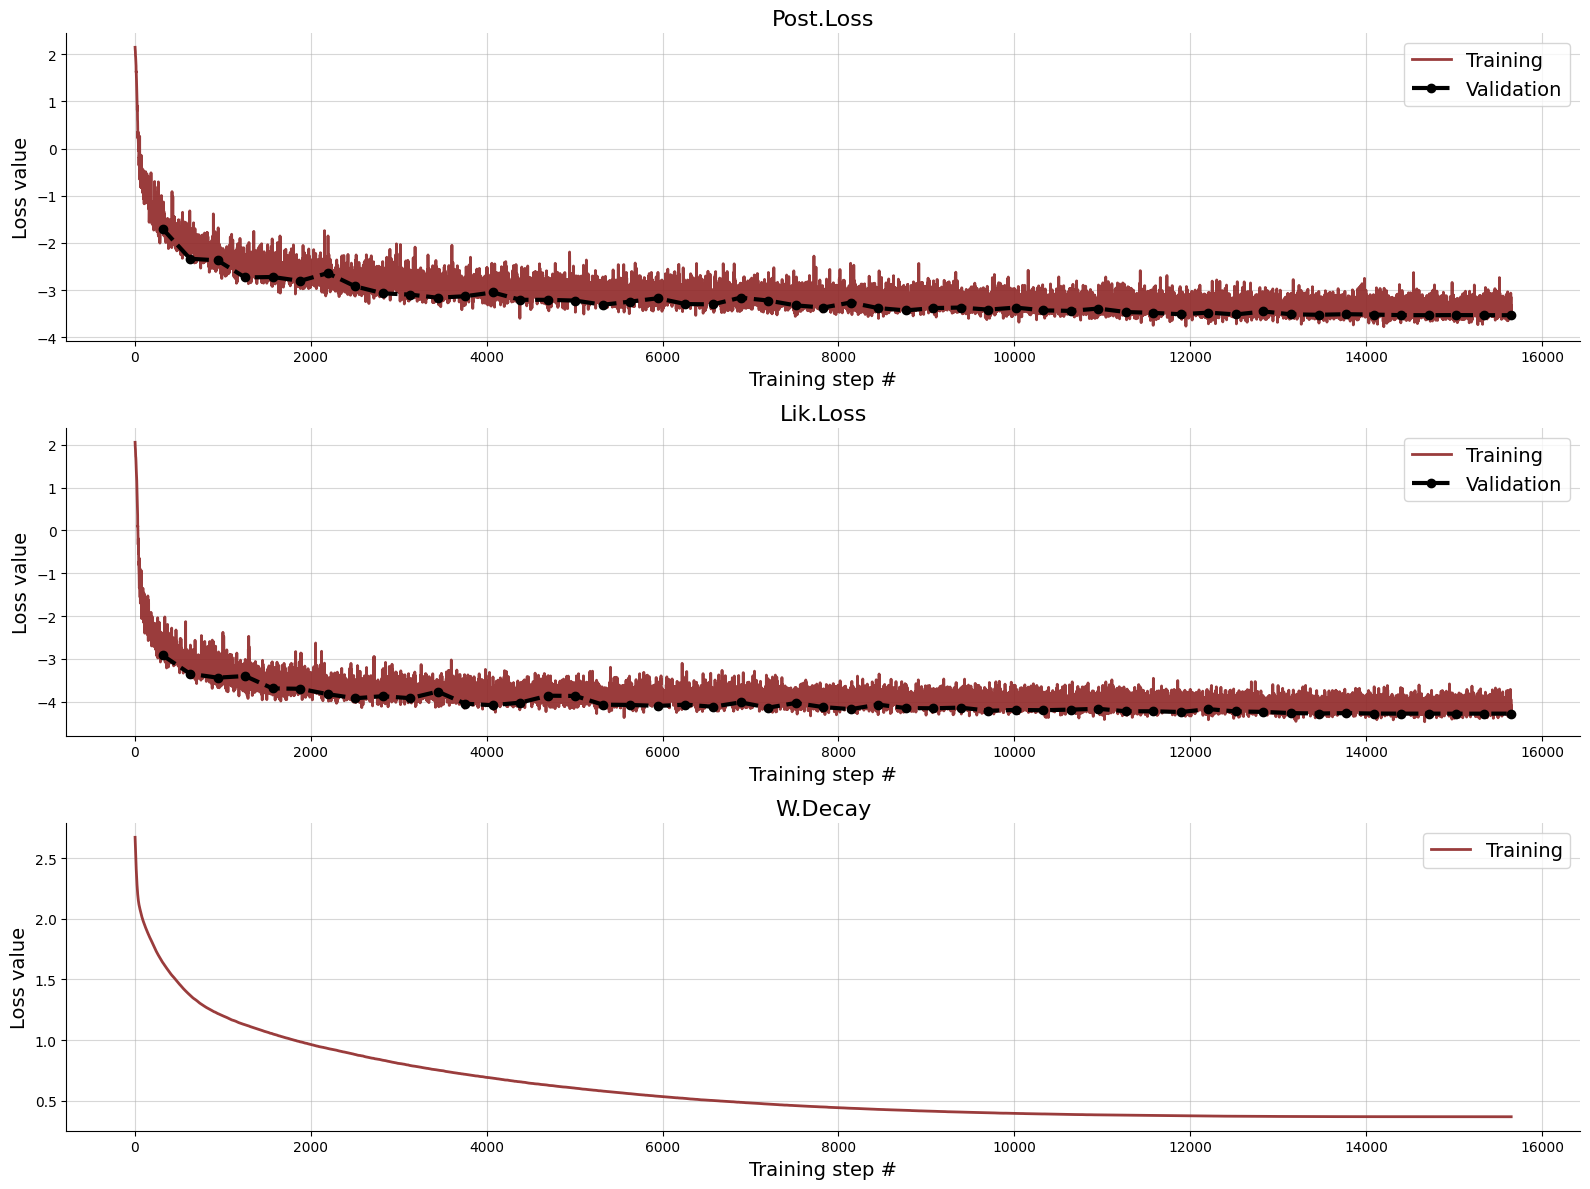

In [13]:
# Use loaded history, since reference 'h' will only exist after training
h = trainer.loss_history.get_plottable()
f = plot_losses(h['train_losses'], h['val_losses'])

## Test Canonical Posterior

In [14]:
samples = amortizer.sample_parameters({'direct_conditions': np.zeros((1, 2), dtype=np.float32)}, 1000)

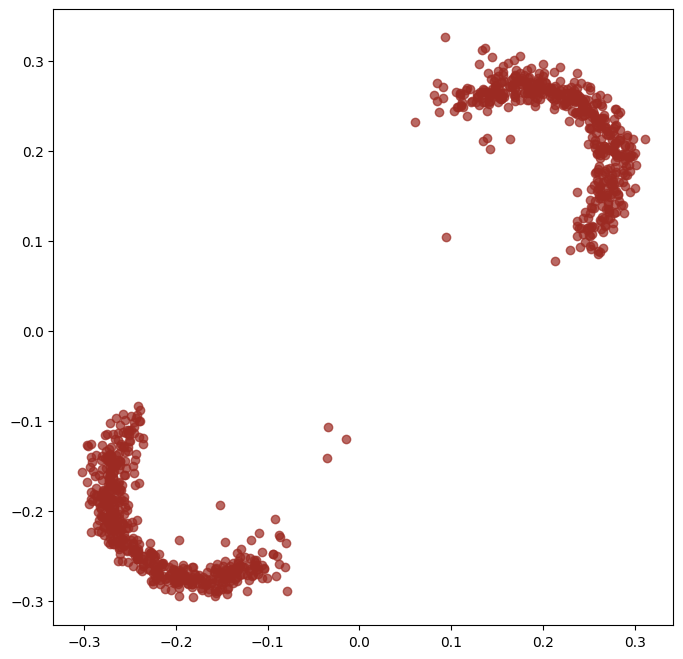

In [15]:
f, ax = plt.subplots(1, 1, figsize=(8, 8))
ax.scatter(samples[:, 0], samples[:, 1], color='#9c2a22', alpha=0.7)

In [16]:
# Load test data
with open(f'test_data/{benchmark_name}_test.pkl', 'rb') as f:
    test_dict = pickle.load(f)

In [22]:
# Simulate from surrogate simulator
x_sim_s = amortizer.sample_data(test_dict, n_samples=1)
x_sim_s = tf.squeeze(x_sim_s)

# Sample from posteriors given surrogate outputs
post_samples_s = amortizer.sample_parameters({'direct_conditions': x_sim_s}, n_samples=250)

# Sample from posteriors given simulator outputs
post_samples = amortizer.sample_parameters(test_dict, n_samples=250)

# Prior samples
prior_samples = test_dict['posterior_inputs']['parameters']

# Appendix Plots

In [23]:
# load custom tighter plotting function
from custom_plots import plot_sbc_ecdf_appendix

# adjust for better readability
plt.rcParams.update({
    "text.usetex": False,
    "font.family": "serif",
    'text.latex.preamble' : r'\usepackage{{amsmath}}'
})

### Loss History

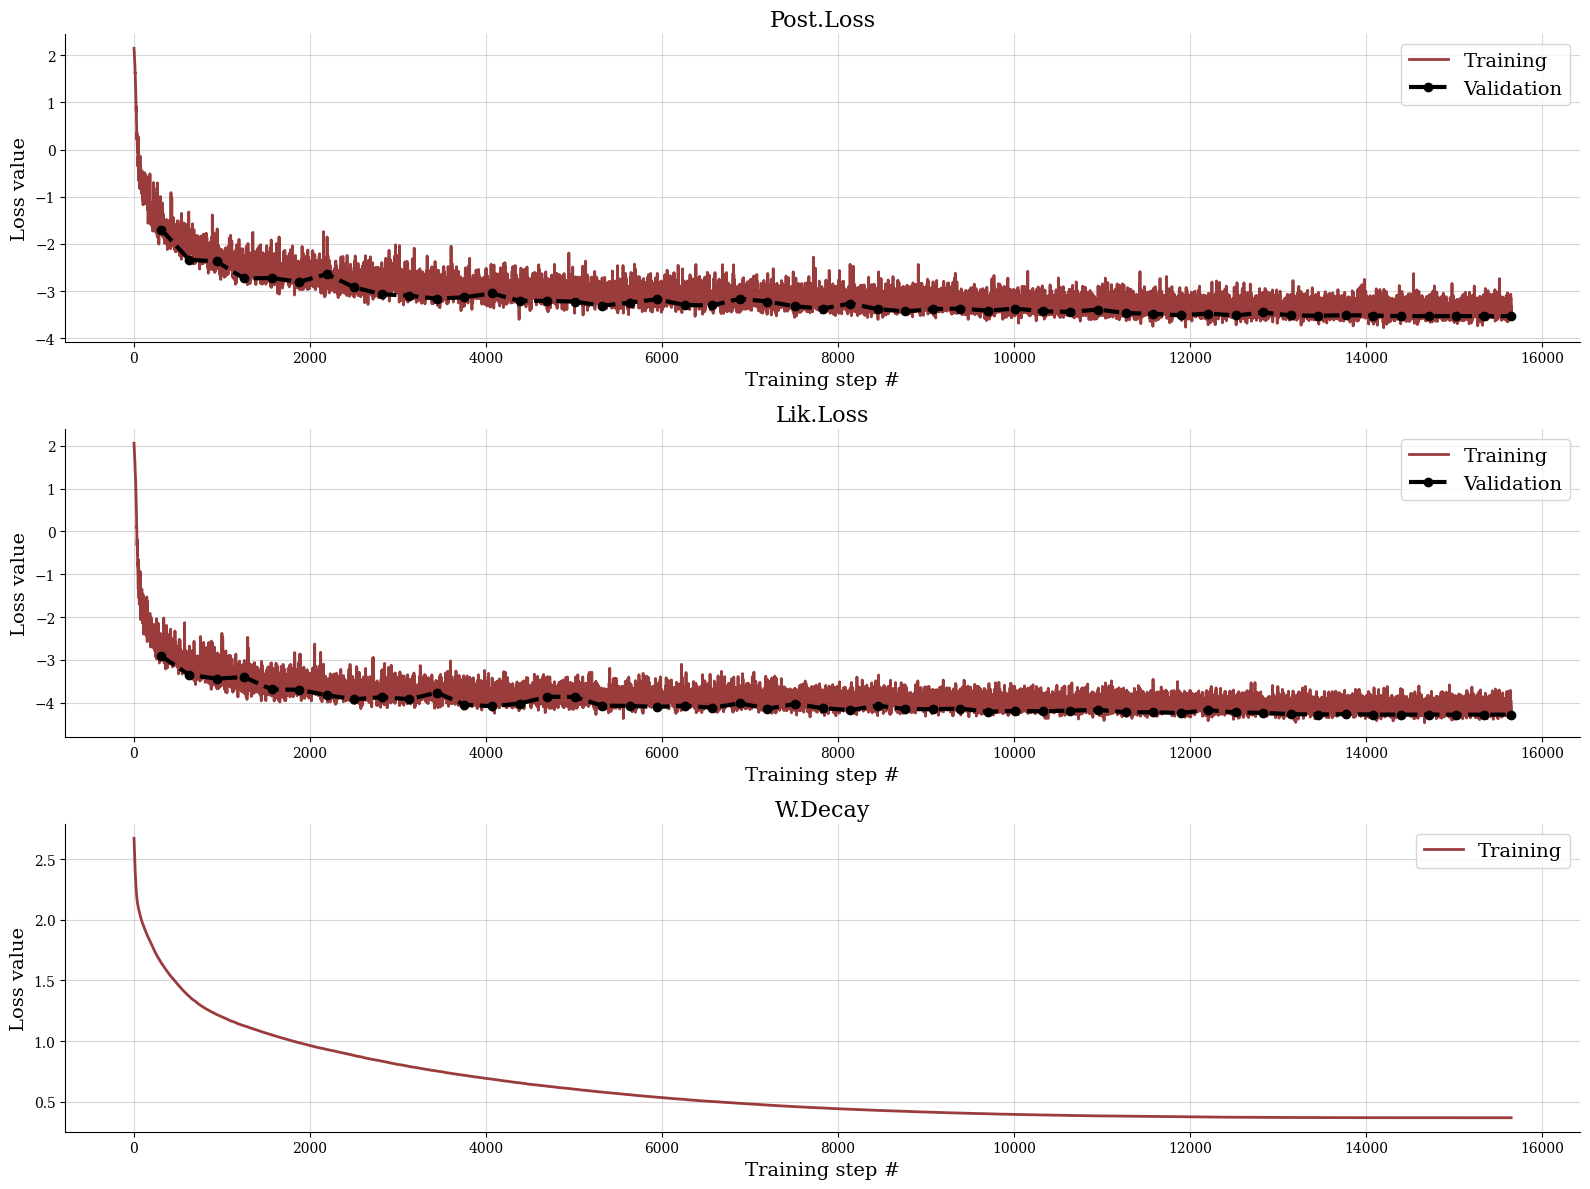

In [24]:
# Use loaded history, since reference 'h' will only exist after training
h = trainer.loss_history.get_plottable()
f = plot_losses(h['train_losses'], h['val_losses'])
plt.savefig(f"figures/{benchmark_name}_losses.pdf", dpi=300, bbox_inches="tight")

### Posterior Calibration

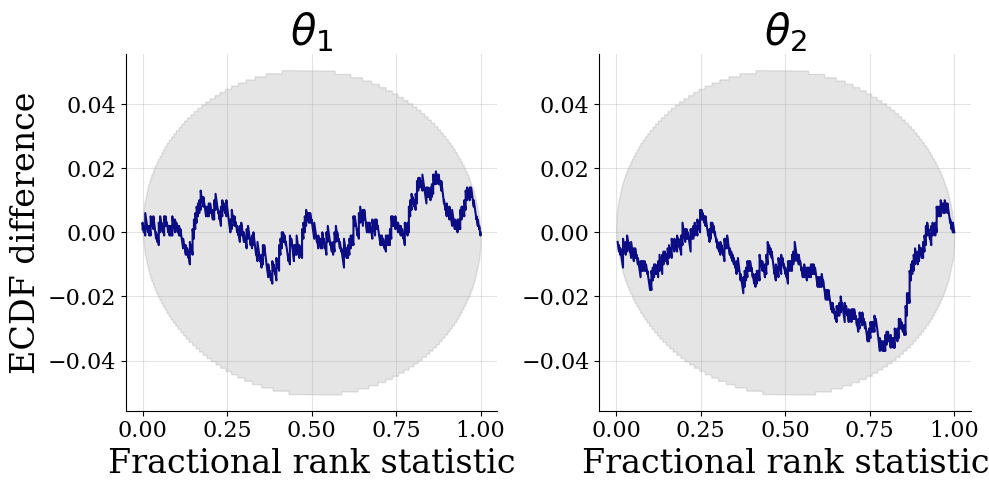

In [25]:
f = plot_sbc_ecdf_appendix(
    post_samples, 
    prior_samples, 
    ecdf_bands_kwargs=dict(confidence=0.95), 
    param_names=benchmark.benchmark_info['parameter_names'],
    label_fontsize=24, 
    legend_fontsize=24, 
    difference=True, 
    rank_ecdf_color='#000080'
)

plt.savefig(f"figures/{benchmark_name}_posterior_calibration_diff_separate.pdf", dpi=300, bbox_inches="tight")

### Joint Calibration

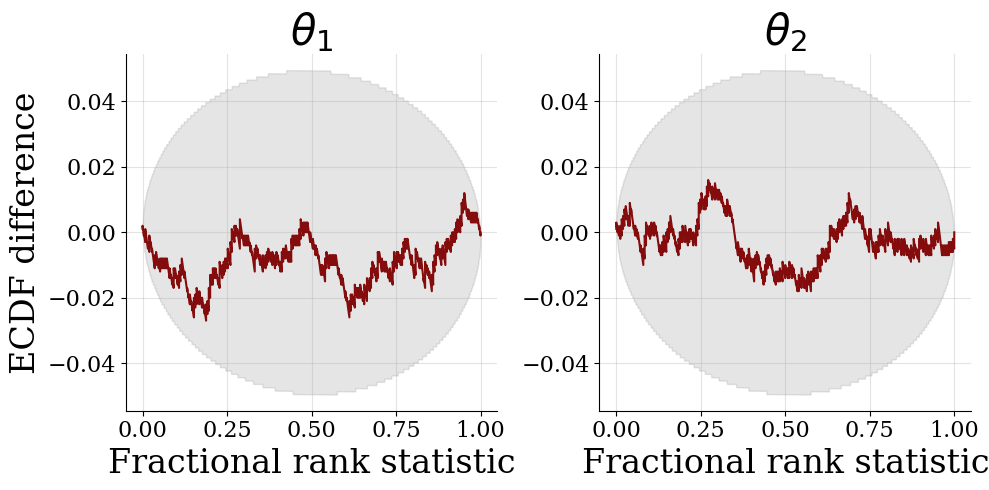

In [26]:
f = plot_sbc_ecdf_appendix(
    post_samples_s, 
    prior_samples, 
    ecdf_bands_kwargs=dict(confidence=0.95), 
    param_names=benchmark.benchmark_info['parameter_names'],
    label_fontsize=24, 
    legend_fontsize=24, 
    difference=True, 
    rank_ecdf_color='#800000'
)

plt.savefig(f"figures/{benchmark_name}_joint_calibration_diff_separate.pdf", dpi=300, bbox_inches="tight")